In [371]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import interp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


import matplotlib as mpl
from matplotlib.pyplot import cm 


mpl.rc("savefig", dpi=100)

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}

#mpl.rc('font', **font)


np.set_printoptions(suppress=True)

%matplotlib inline

In [175]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def runModel(model, X_train, Y_train, X_test):
    """
    performs fitting of [model] using [X_train] and [Y_train]
    returns accuracy on training set, and predictions on [X_test]
    """
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    accuracy = round(model.score(X_train, Y_train) * 100, 2)
    return accuracy, Y_pred

def runLogisticRegression(X_train, Y_train, X_test):
    """
    runs logistic regression
    returns accuracy on training set, and predictions
    """
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    accuracy = round(model.score(X_train, Y_train) * 100, 2)
    Y_pred_prob = model.predict_proba(X_test)
    return accuracy, Y_pred, Y_pred_prob, model.coef_

def runSVM(X_train, Y_train, X_test):
    """
    runs support vector machine
    returns accuracy on training set, and predictions
    """
    svc = SVC()
    return runModel(svc, X_train, Y_train, X_test)

def runRandomForest(X_train, Y_train, X_test, n_estimators = 300):
    """
    runs random forest with [n_estimators] estimators
    returns accuracy on training set, and predictions
    """
    random_forest = RandomForestClassifier(n_estimators=300)
    return runModel(random_forest, X_train, Y_train, X_test)

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model


def runLinearRegression(X_train, Y_train, X_test):
    regr = linear_model.LinearRegression()

    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred_test = regr.predict(X_test)
    Y_pred_train = regr.predict(X_train)

    return Y_pred_test, Y_pred_train

def get_R2(Y_pred, Y_actual):
    return r2_score(Y_actual, Y_pred)

In [158]:
# LOADING DATA

fin = 'lol_dat.npz'
fin = 'lol_dat_challenger.npz'

npzfile = np.load(fin)
npzfile.files

['current_gold',
 'total_gold',
 'xp',
 'max_current_gold',
 'max_total_gold',
 'max_xp',
 'team_stats',
 'winners',
 'num_frames',
 'champions',
 'duration',
 'versions',
 'game_types',
 'player_tiers']

In [161]:
# LOADING DATA

fin = 'lol_dat.npz'
fin2 = 'lol_dat_challenger_2.npz'

npzfile = np.load(fin2)
npzfile.files

['current_gold',
 'total_gold',
 'xp',
 'max_current_gold',
 'max_total_gold',
 'max_xp',
 'team_stats',
 'winners',
 'num_frames',
 'champions',
 'duration',
 'versions',
 'game_types',
 'player_tiers']

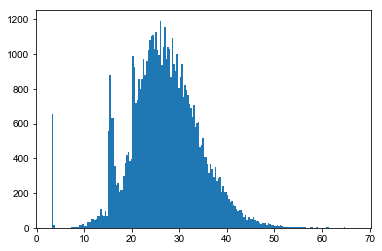

In [160]:
plt.hist(npzfile2['duration']/60,bins=200);

In [23]:
print(np.unique(npzfile['versions']))
print(np.unique(npzfile['game_types']))

['8.1.213.4336' '8.1.214.5847' '8.10.229.7328' '8.11.231.7304'
 '8.11.232.7066' '8.11.232.8721' '8.12.233.4186' '8.13.235.3406'
 '8.13.235.9749' '8.14.238.1713' '8.14.238.9731' '8.14.239.6309'
 '8.15.239.9021' '8.16.241.6543' '8.17.243.3340' '8.2.215.824'
 '8.2.216.1199' '8.3.217.1022' '8.4.218.8787' '8.5.220.3006'
 '8.6.222.2149' '8.7.223.9264' '8.7.224.5563' '8.8.225.6906'
 '8.8.226.7254' '8.9.227.7511' '8.9.228.4283']
['MATCHED_GAME']


In [162]:
min_ranking = 5 # 4: platinum
fraction_cutoff = 0 # require this number of players to have min_ranking
min_duration = 25
max_duration = 60

valid_games = np.where(
    (np.sum(npzfile['player_tiers']>min_ranking,axis=1) >= fraction_cutoff) &
    (npzfile['duration']/60 >= min_duration) &
    (npzfile['duration']/60 <= max_duration)
    )[0]
print(len(valid_games))

48193


In [163]:
Y = npzfile['winners']
n = len(Y)
print(Y.shape)
print(n, 'matches')

(56147,)
56147 matches


In [237]:
Y = (Y+1)%2

In [164]:
max_frames = np.max(npzfile['num_frames'])
max_frames

68

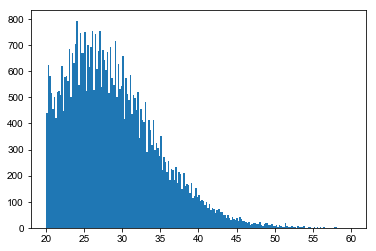

In [174]:
plt.hist(npzfile2['duration'][valid_games]/60,bins=200);

In [311]:
# predict just using lead in total gold


base_fpr = np.linspace(0, 1, 101)

scaler = MinMaxScaler()

cur_X_for_scaling = npzfile['total_gold']

min_x = np.min(cur_X_for_scaling)
max_x = np.max(cur_X_for_scaling)

cur_X_for_scaling = (cur_X_for_scaling - min_x) / (max_x - min_x)
cur_X_for_scaling = cur_X_for_scaling * 2 - 1 # scale to -1 to 1

all_train = []
all_test = []
all_auc = []

for lag in range(40):
    print(lag)
    acc_train_list = []
    acc_test_list = []
    valid_frames = []
    roc_curves = []
    auc = []
    sample_size = []
    coef = []
    for frame in range(40):
        earliest_frame = max(0,frame-lag)
        #X = npzfile['total_gold'][:,earliest_frame:frame+1,2][valid_games]
        X = cur_X_for_scaling[:,earliest_frame:frame+1,2][valid_games]

        indices = np.where(npzfile['num_frames'][valid_games] > frame)[0]
        """
        m = len(X)
        if frame <= min_duration:
            indices = range(m)
        else:
            indices = np.where(X[:,-1] != 0)[0]
        X = X.reshape((m,len(X[0])))
        """

        if len(indices) == 0:
            continue
        # print('frame: ', frame,', number of matches: ',len(indices[0]))
        try:
            skf = StratifiedKFold(n_splits=5)
            skf.get_n_splits(X[indices], Y[valid_games][indices])
            avg_acc_test = []
            avg_acc_train = []
            cur_roc_fpr = []
            cur_roc_tpr = []
            cur_auc = []
            cur_coef = []
            for train_indices, test_indices in skf.split(X[indices], Y[valid_games][indices]):
                X_train = X[indices][train_indices]
                X_test = X[indices][test_indices]
                y_train = Y[valid_games][indices][train_indices]
                y_test = Y[valid_games][indices][test_indices]
                cur_acc_train, y_pred, y_pred_prob, model_coef = runLogisticRegression(X_train, y_train, X_test)
                cur_coef.append(model_coef)
                y_pred_prob = y_pred_prob[:,1]
                avg_acc_train.append(cur_acc_train)
                cur_acc_test = accuracy_score(y_test, y_pred)*100
                avg_acc_test.append(cur_acc_test)
                fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=1)
                tpr = interp(base_fpr, fpr, tpr)
                tpr[0] = 0.0
                cur_roc_tpr.append(tpr)
                cur_auc.append(metrics.roc_auc_score(y_test, y_pred_prob))
            coef.append(np.array(cur_coef).mean(axis=0))
            roc_curves.append([base_fpr,np.array(cur_roc_tpr).mean(axis=0)])
            auc.append(np.mean(cur_auc))
            acc_train = np.mean(avg_acc_train)
            acc_test = np.mean(avg_acc_test)
            acc_train_list.append(acc_train)
            acc_test_list.append(acc_test)
            valid_frames.append(frame)

            print('frame: %d, train: %0.2f, test: %0.2f, AUC: %0.2f, N %d ' % (frame, acc_train, acc_test,
                                                                               np.mean(cur_auc), len(indices)), end='')
            print(X[indices].shape)
        except:
            print('frame: ', frame, '...issue')
    all_train.append(acc_train_list)
    all_test.append(acc_test_list)
    all_auc.append(np.array(auc)*100)

0
frame: 0, train: 52.41, test: 52.41, AUC: 0.50, N 48193 (48193, 1)
frame: 1, train: 52.41, test: 52.41, AUC: 0.51, N 48193 (48193, 1)
frame: 2, train: 52.41, test: 52.41, AUC: 0.54, N 48193 (48193, 1)
frame: 3, train: 55.14, test: 55.12, AUC: 0.61, N 48193 (48193, 1)
frame: 4, train: 59.53, test: 59.51, AUC: 0.64, N 48193 (48193, 1)
frame: 5, train: 61.70, test: 61.72, AUC: 0.67, N 48193 (48193, 1)
frame: 6, train: 63.52, test: 63.52, AUC: 0.69, N 48193 (48193, 1)
frame: 7, train: 65.48, test: 65.45, AUC: 0.71, N 48193 (48193, 1)
frame: 8, train: 66.66, test: 66.67, AUC: 0.73, N 48193 (48193, 1)
frame: 9, train: 68.06, test: 68.09, AUC: 0.74, N 48193 (48193, 1)
frame: 10, train: 69.45, test: 69.45, AUC: 0.76, N 48193 (48193, 1)
frame: 11, train: 70.54, test: 70.53, AUC: 0.78, N 48193 (48193, 1)
frame: 12, train: 71.84, test: 71.83, AUC: 0.79, N 48193 (48193, 1)
frame: 13, train: 73.11, test: 73.09, AUC: 0.81, N 48193 (48193, 1)
frame: 14, train: 74.23, test: 74.25, AUC: 0.82, N 48193

frame: 2, train: 52.41, test: 52.41, AUC: 0.54, N 48193 (48193, 3)
frame: 3, train: 55.57, test: 55.56, AUC: 0.61, N 48193 (48193, 4)
frame: 4, train: 59.89, test: 59.87, AUC: 0.64, N 48193 (48193, 4)
frame: 5, train: 61.88, test: 61.88, AUC: 0.67, N 48193 (48193, 4)
frame: 6, train: 63.42, test: 63.39, AUC: 0.69, N 48193 (48193, 4)
frame: 7, train: 65.30, test: 65.29, AUC: 0.71, N 48193 (48193, 4)
frame: 8, train: 66.68, test: 66.67, AUC: 0.72, N 48193 (48193, 4)
frame: 9, train: 67.92, test: 67.89, AUC: 0.74, N 48193 (48193, 4)
frame: 10, train: 69.15, test: 69.15, AUC: 0.76, N 48193 (48193, 4)
frame: 11, train: 70.56, test: 70.56, AUC: 0.78, N 48193 (48193, 4)
frame: 12, train: 71.76, test: 71.73, AUC: 0.79, N 48193 (48193, 4)
frame: 13, train: 72.98, test: 72.98, AUC: 0.80, N 48193 (48193, 4)
frame: 14, train: 74.19, test: 74.19, AUC: 0.82, N 48193 (48193, 4)
frame: 15, train: 75.39, test: 75.40, AUC: 0.83, N 48193 (48193, 4)
frame: 16, train: 76.60, test: 76.61, AUC: 0.85, N 48193

frame: 4, train: 59.92, test: 59.92, AUC: 0.64, N 48193 (48193, 5)
frame: 5, train: 61.90, test: 61.94, AUC: 0.67, N 48193 (48193, 6)
frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.25, test: 65.26, AUC: 0.71, N 48193 (48193, 7)
frame: 8, train: 66.60, test: 66.59, AUC: 0.72, N 48193 (48193, 7)
frame: 9, train: 67.89, test: 67.89, AUC: 0.74, N 48193 (48193, 7)
frame: 10, train: 69.33, test: 69.34, AUC: 0.76, N 48193 (48193, 7)
frame: 11, train: 70.55, test: 70.54, AUC: 0.78, N 48193 (48193, 7)
frame: 12, train: 71.71, test: 71.71, AUC: 0.79, N 48193 (48193, 7)
frame: 13, train: 72.96, test: 72.96, AUC: 0.80, N 48193 (48193, 7)
frame: 14, train: 74.18, test: 74.18, AUC: 0.82, N 48193 (48193, 7)
frame: 15, train: 75.32, test: 75.31, AUC: 0.83, N 48193 (48193, 7)
frame: 16, train: 76.61, test: 76.60, AUC: 0.85, N 48193 (48193, 7)
frame: 17, train: 77.73, test: 77.76, AUC: 0.86, N 48193 (48193, 7)
frame: 18, train: 78.81, test: 78.81, AUC: 0.87, N 481

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.31, AUC: 0.76, N 48193 (48193, 10)
frame: 11, train: 70.52, test: 70.50, AUC: 0.78, N 48193 (48193, 10)
frame: 12, train: 71.70, test: 71.69, AUC: 0.79, N 48193 (48193, 10)
frame: 13, train: 73.05, test: 73.05, AUC: 0.80, N 48193 (48193, 10)
frame: 14, train: 74.17, test: 74.15, AUC: 0.82, N 48193 (48193, 10)
frame: 15, train: 75.32, test: 75.32, AUC: 0.83, N 48193 (48193, 10)
frame: 16, train: 76.56, test: 76.55, AUC: 0.85, N 48193 (48193, 10)
frame: 17, train: 77.67, test: 77.69, AUC: 0.86, N 48193 (48193, 10)
frame: 18, train: 78.78, test: 78.78, AUC: 0.87, N 48193 (48193, 10)
frame: 19, train: 79.72, test: 79.72, AUC: 0.88, N 48193 (48193, 10)
frame: 20, train: 80.68, test: 80.68, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.96, test: 72.97, AUC: 0.80, N 48193 (48193, 13)
frame: 14, train: 74.16, test: 74.16, AUC: 0.82, N 48193 (48193, 13)
frame: 15, train: 75.35, test: 75.35, AUC: 0.83, N 48193 (48193, 13)
frame: 16, train: 76.57, test: 76.56, AUC: 0.84, N 48193 (48193, 13)
frame: 17, train: 77.60, test: 77.59, AUC: 0.86, N 48193 (48193, 13)
frame: 18, train: 78.80, test: 78.80, AUC: 0.87, N 48193 (48193, 13)
frame: 19, train: 79.77, test: 79.77, AUC: 0.88, N 48193 (48193, 13)
frame: 20, train: 80.64, test: 80.65, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.97, test: 72.96, AUC: 0.80, N 48193 (48193, 14)
frame: 14, train: 74.18, test: 74.17, AUC: 0.82, N 48193 (48193, 15)
frame: 15, train: 75.34, test: 75.34, AUC: 0.83, N 48193 (48193, 16)
frame: 16, train: 76.53, test: 76.54, AUC: 0.84, N 48193 (48193, 16)
frame: 17, train: 77.57, test: 77.57, AUC: 0.86, N 48193 (48193, 16)
frame: 18, train: 78.77, test: 78.76, AUC: 0.87, N 48193 (48193, 16)
frame: 19, train: 79.75, test: 79.75, AUC: 0.88, N 48193 (48193, 16)
frame: 20, train: 80.62, test: 80.61, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.97, test: 72.96, AUC: 0.80, N 48193 (48193, 14)
frame: 14, train: 74.18, test: 74.17, AUC: 0.82, N 48193 (48193, 15)
frame: 15, train: 75.34, test: 75.34, AUC: 0.83, N 48193 (48193, 16)
frame: 16, train: 76.53, test: 76.52, AUC: 0.84, N 48193 (48193, 17)
frame: 17, train: 77.63, test: 77.64, AUC: 0.86, N 48193 (48193, 18)
frame: 18, train: 78.81, test: 78.80, AUC: 0.87, N 48193 (48193, 19)
frame: 19, train: 79.72, test: 79.70, AUC: 0.88, N 48193 (48193, 19)
frame: 20, train: 80.67, test: 80.68, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.97, test: 72.96, AUC: 0.80, N 48193 (48193, 14)
frame: 14, train: 74.18, test: 74.17, AUC: 0.82, N 48193 (48193, 15)
frame: 15, train: 75.34, test: 75.34, AUC: 0.83, N 48193 (48193, 16)
frame: 16, train: 76.53, test: 76.52, AUC: 0.84, N 48193 (48193, 17)
frame: 17, train: 77.63, test: 77.64, AUC: 0.86, N 48193 (48193, 18)
frame: 18, train: 78.81, test: 78.80, AUC: 0.87, N 48193 (48193, 19)
frame: 19, train: 79.75, test: 79.74, AUC: 0.88, N 48193 (48193, 20)
frame: 20, train: 80.67, test: 80.68, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.97, test: 72.96, AUC: 0.80, N 48193 (48193, 14)
frame: 14, train: 74.18, test: 74.17, AUC: 0.82, N 48193 (48193, 15)
frame: 15, train: 75.34, test: 75.34, AUC: 0.83, N 48193 (48193, 16)
frame: 16, train: 76.53, test: 76.52, AUC: 0.84, N 48193 (48193, 17)
frame: 17, train: 77.63, test: 77.64, AUC: 0.86, N 48193 (48193, 18)
frame: 18, train: 78.81, test: 78.80, AUC: 0.87, N 48193 (48193, 19)
frame: 19, train: 79.75, test: 79.74, AUC: 0.88, N 48193 (48193, 20)
frame: 20, train: 80.67, test: 80.68, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.97, test: 72.96, AUC: 0.80, N 48193 (48193, 14)
frame: 14, train: 74.18, test: 74.17, AUC: 0.82, N 48193 (48193, 15)
frame: 15, train: 75.34, test: 75.34, AUC: 0.83, N 48193 (48193, 16)
frame: 16, train: 76.53, test: 76.52, AUC: 0.84, N 48193 (48193, 17)
frame: 17, train: 77.63, test: 77.64, AUC: 0.86, N 48193 (48193, 18)
frame: 18, train: 78.81, test: 78.80, AUC: 0.87, N 48193 (48193, 19)
frame: 19, train: 79.75, test: 79.74, AUC: 0.88, N 48193 (48193, 20)
frame: 20, train: 80.67, test: 80.68, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.97, test: 72.96, AUC: 0.80, N 48193 (48193, 14)
frame: 14, train: 74.18, test: 74.17, AUC: 0.82, N 48193 (48193, 15)
frame: 15, train: 75.34, test: 75.34, AUC: 0.83, N 48193 (48193, 16)
frame: 16, train: 76.53, test: 76.52, AUC: 0.84, N 48193 (48193, 17)
frame: 17, train: 77.63, test: 77.64, AUC: 0.86, N 48193 (48193, 18)
frame: 18, train: 78.81, test: 78.80, AUC: 0.87, N 48193 (48193, 19)
frame: 19, train: 79.75, test: 79.74, AUC: 0.88, N 48193 (48193, 20)
frame: 20, train: 80.67, test: 80.68, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.97, test: 72.96, AUC: 0.80, N 48193 (48193, 14)
frame: 14, train: 74.18, test: 74.17, AUC: 0.82, N 48193 (48193, 15)
frame: 15, train: 75.34, test: 75.34, AUC: 0.83, N 48193 (48193, 16)
frame: 16, train: 76.53, test: 76.52, AUC: 0.84, N 48193 (48193, 17)
frame: 17, train: 77.63, test: 77.64, AUC: 0.86, N 48193 (48193, 18)
frame: 18, train: 78.81, test: 78.80, AUC: 0.87, N 48193 (48193, 19)
frame: 19, train: 79.75, test: 79.74, AUC: 0.88, N 48193 (48193, 20)
frame: 20, train: 80.67, test: 80.68, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.97, test: 72.96, AUC: 0.80, N 48193 (48193, 14)
frame: 14, train: 74.18, test: 74.17, AUC: 0.82, N 48193 (48193, 15)
frame: 15, train: 75.34, test: 75.34, AUC: 0.83, N 48193 (48193, 16)
frame: 16, train: 76.53, test: 76.52, AUC: 0.84, N 48193 (48193, 17)
frame: 17, train: 77.63, test: 77.64, AUC: 0.86, N 48193 (48193, 18)
frame: 18, train: 78.81, test: 78.80, AUC: 0.87, N 48193 (48193, 19)
frame: 19, train: 79.75, test: 79.74, AUC: 0.88, N 48193 (48193, 20)
frame: 20, train: 80.67, test: 80.68, AUC

frame: 6, train: 63.35, test: 63.36, AUC: 0.69, N 48193 (48193, 7)
frame: 7, train: 65.24, test: 65.26, AUC: 0.71, N 48193 (48193, 8)
frame: 8, train: 66.59, test: 66.60, AUC: 0.72, N 48193 (48193, 9)
frame: 9, train: 67.81, test: 67.84, AUC: 0.74, N 48193 (48193, 10)
frame: 10, train: 69.31, test: 69.29, AUC: 0.76, N 48193 (48193, 11)
frame: 11, train: 70.52, test: 70.52, AUC: 0.78, N 48193 (48193, 12)
frame: 12, train: 71.70, test: 71.68, AUC: 0.79, N 48193 (48193, 13)
frame: 13, train: 72.97, test: 72.96, AUC: 0.80, N 48193 (48193, 14)
frame: 14, train: 74.18, test: 74.17, AUC: 0.82, N 48193 (48193, 15)
frame: 15, train: 75.34, test: 75.34, AUC: 0.83, N 48193 (48193, 16)
frame: 16, train: 76.53, test: 76.52, AUC: 0.84, N 48193 (48193, 17)
frame: 17, train: 77.63, test: 77.64, AUC: 0.86, N 48193 (48193, 18)
frame: 18, train: 78.81, test: 78.80, AUC: 0.87, N 48193 (48193, 19)
frame: 19, train: 79.75, test: 79.74, AUC: 0.88, N 48193 (48193, 20)
frame: 20, train: 80.67, test: 80.68, AUC

In [324]:
fout_analysis = 'accuracy_vs_lag.npz'
np.savez(fout_analysis, all_train = all_train, all_test = all_test, all_auc = all_auc)

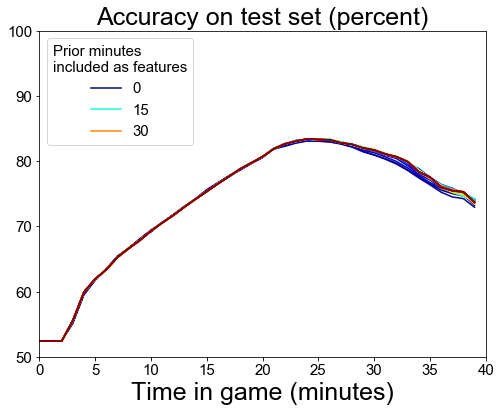

In [405]:
fout_analysis = 'accuracy_vs_lag.npz'
accuracy_lag = np.load(fout_analysis)
all_train = accuracy_lag['all_train']
all_test = accuracy_lag['all_test']
all_auc = accuracy_lag['all_auc']

color=cm.jet(np.linspace(0,1,len(all_train)))

fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(all_train)):
    if i == 0 or i==15 or i==30:
        plt.plot(all_test[i], color=color[i],label=i)
    else:
        plt.plot(all_test[i], color=color[i])

#plt.ylim([75,85])

legend = plt.legend(title='Prior minutes\nincluded as features', fontsize=15)
legend._legend_box.align = "center"
plt.setp(legend.get_title(),fontsize=15)



ax.set_xticks(np.arange(0,40,5),minor=True)
plt.ylim([50,100])
plt.xlim([0,40])
ax.tick_params(labelsize=15)
plt.xlabel('Time in game (minutes)', fontsize=25)
plt.title('Accuracy on test set (percent)', fontsize=25)

plt.savefig('accuracy_vs_lag.png',dpi=200)

In [312]:
fout_analysis = 'vs_lag_all_train.txt'
with open(fout_analysis,'w') as f:
    for i, x in enumerate(valid_frames):
        cur_out = '%d, %d, %0.2f, %0.2f\n' %(i, x, acc_test_list[i], np.array(auc)[i]*100)
        f.write(cur_out)

(40, 40)

In [300]:
fout_analysis = 'analysis.txt'
with open(fout_analysis,'w') as f:
    for i, x in enumerate(valid_frames):
        cur_out = '%d, %d, %0.2f, %0.2f\n' %(i, x, acc_test_list[i], np.array(auc)[i]*100)
        f.write(cur_out)

1.0

Text(0.5,1,'Odds($x+1$)/Odds($x$) $\\equiv e^\\beta$')

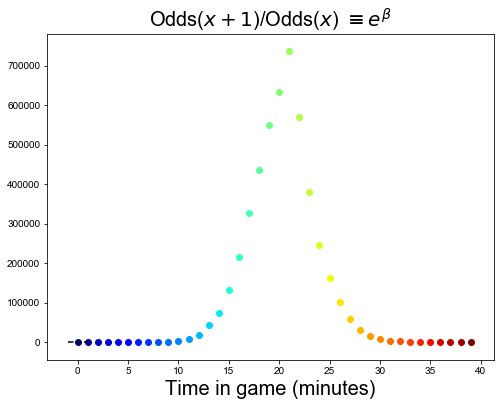

In [348]:
color=cm.jet(np.linspace(0,1,len(coef)))

fig, ax = plt.subplots(figsize=(8,6))

for i, cur_coef in enumerate(coef):
#    print(np.exp(cur_coef[0]))
#    plt.plot(range(len(cur_coef[0])), np.exp(cur_coef[0]), label=i, color=color[i])
    plt.scatter(i, np.exp(cur_coef[0]), label=i, color=color[i])
    
plt.hlines(0,-1,1,linestyles='--')
plt.xlabel('Time in game (minutes)',fontsize=20)
plt.title(r'Odds($X+1$)/Odds($X$) $\equiv e^\beta$',fontsize=20)

In [349]:
(max_x - min_x)

149724

In [331]:
import random

random.seed(1)
random_set = np.sort(random.sample(range(30000),10000))
random_set

array([    7,     8,    11, ..., 29990, 29996, 29997])

In [406]:
# predict just using lead in total gold

# only looking at a subset (fixing N)


base_fpr = np.linspace(0, 1, 101)

scaler = MinMaxScaler()

cur_X_for_scaling = npzfile['total_gold'][valid_games]
cur_Y = Y[valid_games]

only_end_after_40 = np.where(npzfile['num_frames'][valid_games]> 40)[0]



all_train = []
all_test = []
all_auc = []

lag = 1

samplesizes = list(range(100,2600,100))

for sample_size in samplesizes:

    random.seed(1)
    random_set = np.sort(random.sample(list(only_end_after_40),sample_size))

    subset_X = cur_X_for_scaling[random_set]
    subset_Y = cur_Y[random_set]

    min_x = np.min(cur_X_for_scaling)
    max_x = np.max(cur_X_for_scaling)

    cur_X_for_scaling = (cur_X_for_scaling - min_x) / (max_x - min_x)
    cur_X_for_scaling = cur_X_for_scaling * 2 - 1 # scale to -1 to 1


    acc_train_list = []
    acc_test_list = []
    valid_frames = []
    roc_curves = []
    auc = []
    sample_size = []
    coef = []
    for frame in range(20,21):
        earliest_frame = max(0,frame-lag)
        #X = npzfile['total_gold'][:,earliest_frame:frame+1,2][valid_games]
        X = cur_X_for_scaling[:,earliest_frame:frame+1,2]

        indices = np.where(npzfile['num_frames'][valid_games][random_set] > frame)[0]
        """
        m = len(X)
        if frame <= min_duration:
            indices = range(m)
        else:
            indices = np.where(X[:,-1] != 0)[0]
        X = X.reshape((m,len(X[0])))
        """

        if len(indices) == 0:
            continue
        # print('frame: ', frame,', number of matches: ',len(indices[0]))
        try:
            skf = StratifiedKFold(n_splits=5)
            skf.get_n_splits(X[indices], cur_Y[indices])
            avg_acc_test = []
            avg_acc_train = []
            cur_roc_fpr = []
            cur_roc_tpr = []
            cur_auc = []
            cur_coef = []
            for train_indices, test_indices in skf.split(X[indices], cur_Y[indices]):
                X_train = X[indices][train_indices]
                X_test = X[indices][test_indices]
                y_train = cur_Y[indices][train_indices]
                y_test = cur_Y[indices][test_indices]
                cur_acc_train, y_pred, y_pred_prob, model_coef = runLogisticRegression(X_train, y_train, X_test)
                cur_coef.append(model_coef)
                y_pred_prob = y_pred_prob[:,1]
                avg_acc_train.append(cur_acc_train)
                cur_acc_test = accuracy_score(y_test, y_pred)*100
                avg_acc_test.append(cur_acc_test)
                fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=1)
                tpr = interp(base_fpr, fpr, tpr)
                tpr[0] = 0.0
                cur_roc_tpr.append(tpr)
                cur_auc.append(metrics.roc_auc_score(y_test, y_pred_prob))
            coef.append(np.array(cur_coef).mean(axis=0))
            roc_curves.append([base_fpr,np.array(cur_roc_tpr).mean(axis=0)])
            auc.append(np.mean(cur_auc))
            acc_train = np.mean(avg_acc_train)
            acc_test = np.mean(avg_acc_test)
            acc_train_list.append(acc_train)
            acc_test_list.append(acc_test)
            valid_frames.append(frame)

            print('frame: %d, train: %0.2f, test: %0.2f, AUC: %0.2f, N %d ' % (frame, acc_train, acc_test,
                                                                               np.mean(cur_auc), len(indices)), end='')
            print(X[indices].shape)
        except:
            print('frame: ', frame, '...issue')
    all_train.append(acc_train_list)
    all_test.append(acc_test_list)
    all_auc.append(np.array(auc)*100)

frame: 20, train: 61.25, test: 62.07, AUC: 0.90, N 100 (100, 2)
frame: 20, train: 68.50, test: 68.05, AUC: 0.90, N 200 (200, 2)
frame: 20, train: 73.00, test: 72.02, AUC: 0.88, N 300 (300, 2)
frame: 20, train: 76.88, test: 76.75, AUC: 0.90, N 400 (400, 2)
frame: 20, train: 78.35, test: 78.81, AUC: 0.90, N 500 (500, 2)
frame: 20, train: 79.88, test: 79.85, AUC: 0.90, N 600 (600, 2)
frame: 20, train: 80.36, test: 80.30, AUC: 0.91, N 700 (700, 2)
frame: 20, train: 80.97, test: 81.00, AUC: 0.90, N 800 (800, 2)
frame: 20, train: 81.97, test: 81.66, AUC: 0.90, N 900 (900, 2)
frame: 20, train: 81.22, test: 81.10, AUC: 0.90, N 1000 (1000, 2)
frame: 20, train: 81.41, test: 81.36, AUC: 0.90, N 1100 (1100, 2)
frame: 20, train: 81.48, test: 81.50, AUC: 0.90, N 1200 (1200, 2)
frame: 20, train: 82.02, test: 81.92, AUC: 0.90, N 1300 (1300, 2)
frame: 20, train: 82.25, test: 82.29, AUC: 0.91, N 1400 (1400, 2)
frame: 20, train: 82.05, test: 82.07, AUC: 0.91, N 1500 (1500, 2)
frame: 20, train: 81.64, tes

In [407]:
fout_analysis = 'accuracy_vs_samplesize.npz'
np.savez(fout_analysis, all_train = all_train, all_test = all_test, all_auc = all_auc, samplesize = samplesizes)

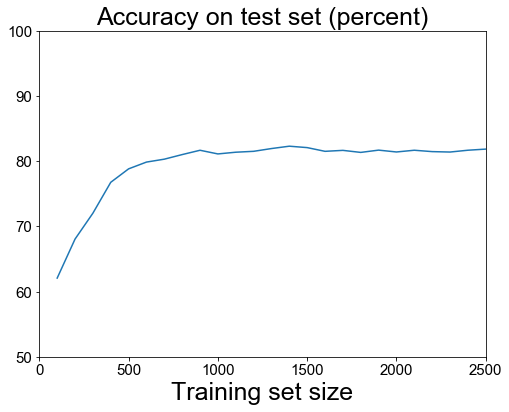

In [415]:
fout_analysis = 'accuracy_vs_samplesize.npz'
accuracy_lag = np.load(fout_analysis)
all_train = accuracy_lag['all_train']
all_test = accuracy_lag['all_test']
all_auc = accuracy_lag['all_auc']
samplesize = accuracy_lag['samplesize']

color=cm.jet(np.linspace(0,1,len(all_train)))

fig, ax = plt.subplots(figsize=(8,6))

plt.plot(samplesize, all_test)


ax.set_xticks(np.arange(0,2600,500),minor=True)
plt.ylim([50,100])
plt.xlim([0,2500])
ax.tick_params(labelsize=15)
plt.xlabel('Training set size', fontsize=25)
plt.title('Accuracy on test set (percent)', fontsize=25)

plt.savefig('accuracy_vs_samplesize (minute 20).png',dpi=200)

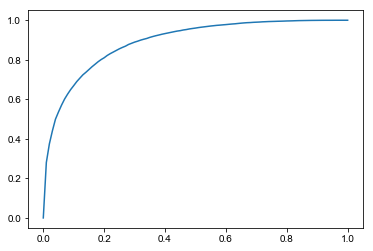

In [223]:
cur_frame = 20

plt.plot(roc_curves[cur_frame][0], roc_curves[cur_frame][1])

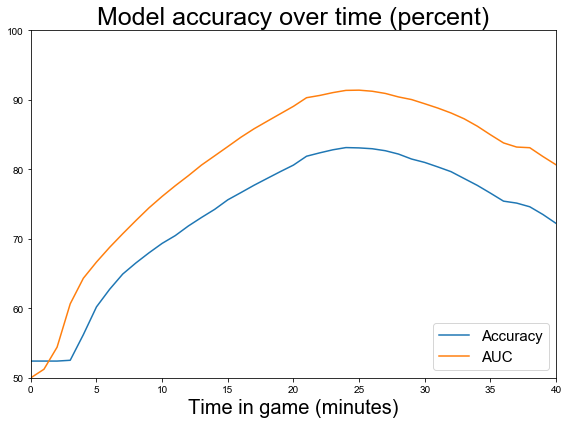

In [294]:
fig, ax = plt.subplots(figsize=(8,6))


plt.plot(valid_frames, acc_test_list, label = 'Accuracy')
plt.plot(valid_frames, np.array(auc)*100, label='AUC')
plt.xlim([0,40])
plt.ylim([50,100])


plt.title('Model accuracy over time (percent)',fontsize=25);
plt.xlabel('Time in game (minutes)',fontsize=20);
plt.legend(fontsize=15,loc='lower right')
ax.tick_params(axis='both',which='both',direction='out')
plt.tight_layout()

In [305]:
fout_analysis = 'analysis.txt'
with open(fout_analysis,'w') as f:
    for i, x in enumerate(valid_frames):
        cur_out = '%d, %d, %0.2f, %0.2f\n' %(i, x, acc_test_list[i], np.array(auc)[i]*100)
        f.write(cur_out)

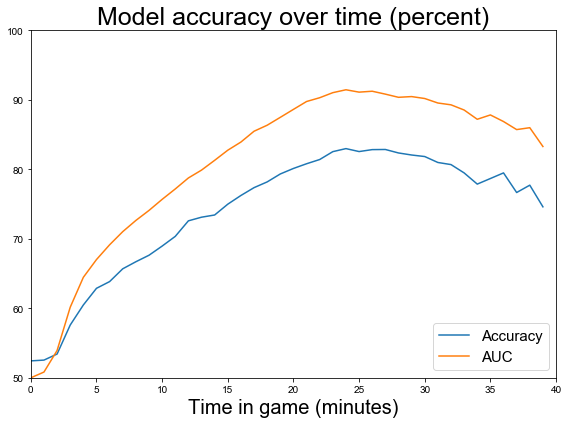

In [151]:
fig, ax = plt.subplots(figsize=(8,6))


plt.plot(valid_frames, acc_test_list, label = 'Accuracy')
plt.plot(valid_frames, np.array(auc)*100, label='AUC')
plt.xlim([0,40])
plt.ylim([50,100])


plt.title('Model accuracy over time (percent)',fontsize=25);
plt.xlabel('Time in game (minutes)',fontsize=20);
plt.legend(fontsize=15,loc='lower right')
ax.tick_params(axis='both',which='both',direction='out')
plt.tight_layout()

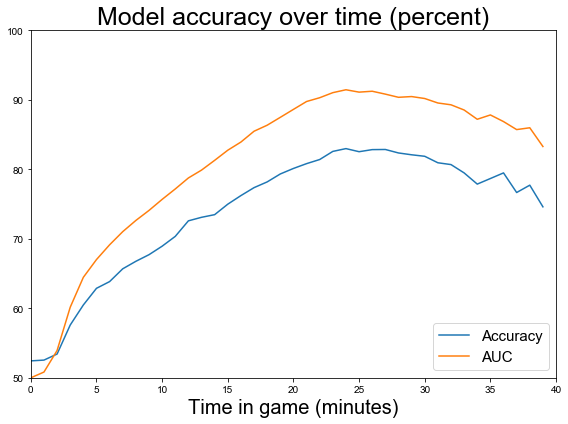

In [144]:
fig, ax = plt.subplots(figsize=(8,6))


plt.plot(valid_frames, acc_test_list, label = 'Accuracy')
plt.plot(valid_frames, np.array(auc)*100, label='AUC')
plt.xlim([0,40])
plt.ylim([50,100])


plt.title('Model accuracy over time (percent)',fontsize=25);
plt.xlabel('Time in game (minutes)',fontsize=20);
plt.legend(fontsize=15,loc='lower right')
ax.tick_params(axis='both',which='both',direction='out')
plt.tight_layout()

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
acc, y_pred = runLogisticRegression(X_train, y_train, X_test)
print('train:' ,acc, '\ntest: ' ,accuracy_score(y_test, y_pred)*100)

train: 51.68 
test:  51.002435825370064


In [6]:
# predict just using lead in current gold

acc_train_list = []
acc_test_list = []
valid_frames = []
for frame in range(max_frames):
    X = npzfile['current_gold'][:,frame,2]
    indices = np.where(X != 0)[0]
    X = X.reshape((n,1))
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  1 , train: 51.53 , test:  53.18655851680185 N:  8627
frame:  2 , train: 53.15 , test:  54.19649960222752 N:  25140
frame:  3 , train: 58.81 , test:  57.47422680412371 N:  25218
frame:  4 , train: 56.89 , test:  57.66249254621347 N:  25154
frame:  5 , train: 54.59 , test:  54.859437751004016 N:  24897
frame:  6 , train: 55.38 , test:  55.6046605062274 N:  24890
frame:  7 , train: 56.37 , test:  55.90361445783133 N:  24897
frame:  8 , train: 56.6 , test:  56.967871485943775 N:  24898
frame:  9 , train: 58.54 , test:  58.62623016670015 N:  24892
frame:  10 , train: 58.49 , test:  58.3283102270444 N:  24882
frame:  11 , train: 58.95 , test:  58.9300080450523 N:  24858
frame:  12 , train: 60.04 , test:  60.50352467270896 N:  24822
frame:  13 , train: 60.08 , test:  59.3939393939394 N:  24746
frame:  14 , train: 61.53 , test:  60.37774167343623 N:  24619
frame:  15 , train: 61.95 , test:  62.5051082958725 N:  24466
frame:  16 , train: 63.56 , test:  63.58762886597938 N:  24250
frame:

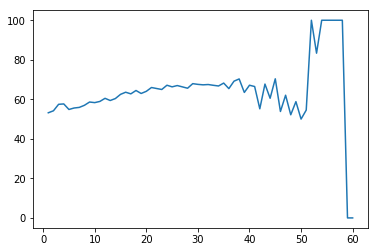

In [7]:
plt.plot(valid_frames, acc_test_list)

In [10]:
# predict just using lead in total gold

acc_train_list = []
acc_test_list = []
valid_frames = []
for frame in range(max_frames):
    X = npzfile['total_gold'][:,frame,2]
    indices = np.where(X != 0)[0]
    X = X.reshape((n,1))
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  1 , train: 55.48 , test:  55.44217687074829 N:  4406
frame:  2 , train: 55.6 , test:  53.80942908295205 N:  25131
frame:  3 , train: 60.75 , test:  58.76288659793815 N:  25218
frame:  4 , train: 63.91 , test:  61.955873583780566 N:  25154
frame:  5 , train: 65.02 , test:  65.66265060240963 N:  24896
frame:  6 , train: 67.01 , test:  66.59971881903996 N:  24893
frame:  7 , train: 68.04 , test:  69.2570281124498 N:  24897
frame:  8 , train: 69.71 , test:  69.93975903614458 N:  24896
frame:  9 , train: 71.72 , test:  70.81157091201285 N:  24889
frame:  10 , train: 72.98 , test:  72.35837685817597 N:  24886
frame:  11 , train: 73.86 , test:  74.84415845566058 N:  24864
frame:  12 , train: 74.89 , test:  75.64954682779457 N:  24825
frame:  13 , train: 76.29 , test:  75.71717171717171 N:  24750
frame:  14 , train: 77.55 , test:  76.26877791311408 N:  24626
frame:  15 , train: 78.17 , test:  78.83122190437271 N:  24466
frame:  16 , train: 78.86 , test:  79.71552257266544 N:  24252
fra

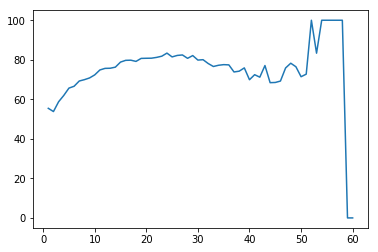

In [11]:
plt.plot(valid_frames, acc_test_list)

In [8]:
# predict just using lead in max total gold

acc_train_list = []
acc_test_list = []
valid_frames = []
for frame in range(max_frames):
    X = npzfile['max_total_gold'][:,frame,2]
    indices = np.where(X != 0)[0]
    X = X.reshape((n,1))
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  1 , train: 54.9 , test:  55.68181818181818 N:  4397
frame:  2 , train: 55.31 , test:  53.03625028861695 N:  21653
frame:  3 , train: 58.85 , test:  58.900260887015854 N:  24914
frame:  4 , train: 61.07 , test:  62.87652104528226 N:  25061
frame:  5 , train: 63.6 , test:  61.768844221105525 N:  24874
frame:  6 , train: 64.2 , test:  65.03918022905366 N:  24881
frame:  7 , train: 65.69 , test:  66.77380474085979 N:  24887
frame:  8 , train: 66.87 , test:  67.32315112540192 N:  24879
frame:  9 , train: 68.17 , test:  68.15990357573322 N:  24887
frame:  10 , train: 69.51 , test:  70.23115577889448 N:  24871
frame:  11 , train: 70.44 , test:  70.8107020720177 N:  24854
frame:  12 , train: 71.76 , test:  71.93229901269393 N:  24815
frame:  13 , train: 72.53 , test:  72.39846433622954 N:  24745
frame:  14 , train: 73.21 , test:  74.26888708367181 N:  24616
frame:  15 , train: 74.07 , test:  75.47516860821581 N:  24463
frame:  16 , train: 75.4 , test:  74.01526087853165 N:  24244
frame

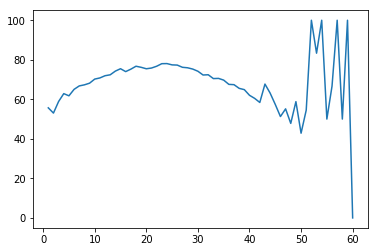

In [9]:
plt.plot(valid_frames, acc_test_list)

In [80]:
# predict just using lead in xp

acc_train_list = []
acc_test_list = []
valid_frames = []
for frame in range(max_frames):
    X = npzfile['xp'][:,frame,2]
    indices = np.where(X != 0)[0]
    X = X.reshape((n,1))
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  1 , train: 57.46 , test:  54.90753911806543 N:  3512
frame:  2 , train: 54.03 , test:  54.52137722285282 N:  26428
frame:  3 , train: 58.57 , test:  58.080239970003745 N:  26667
frame:  4 , train: 60.01 , test:  60.9627679578789 N:  26587
frame:  5 , train: 61.68 , test:  62.20322886989553 N:  26321
frame:  6 , train: 64.91 , test:  62.56410256410256 N:  26324
frame:  7 , train: 66.86 , test:  67.10351377018043 N:  26321
frame:  8 , train: 68.2 , test:  67.9582146248813 N:  26321
frame:  9 , train: 69.76 , test:  70.29646522234891 N:  26309
frame:  10 , train: 71.36 , test:  71.16517772286637 N:  26305
frame:  11 , train: 72.86 , test:  71.9611945976793 N:  26281
frame:  12 , train: 73.97 , test:  73.29902801600915 N:  26232
frame:  13 , train: 75.02 , test:  75.45402408717263 N:  26154
frame:  14 , train: 76.11 , test:  76.1913912375096 N:  26017
frame:  15 , train: 76.49 , test:  77.22082446293787 N:  25833
frame:  16 , train: 77.54 , test:  77.10042985541227 N:  25588
frame:

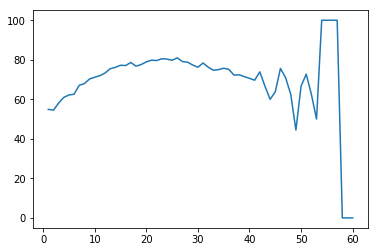

In [81]:
plt.plot(valid_frames, acc_test_list)

In [87]:
X_pre = npzfile['total_gold'][:,:,2]
X_pre.shape

(26683, 65)

In [90]:
lead = 1*(X_pre > 0)
for i in range(max_frames):
    percent_time_with_lead = []

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [98]:
cur_frame = 3
print(lead[:,1:cur_frame+1])
(np.sum(lead[:,1:cur_frame+1],axis=1) / cur_frame).shape

[[1 1 1]
 [0 0 0]
 [0 1 1]
 ...
 [0 0 1]
 [0 1 1]
 [0 0 0]]


(26683,)

In [101]:
# predict using fraction time with lead

acc_train_list = []
acc_test_list = []
valid_frames = []

lead = 1*(npzfile['total_gold'][:,:,2] > 0)

for frame in range(max_frames-1):
    X = npzfile['xp'][:,frame+1,2]
    indices = np.where(X != 0)[0]
    X = np.sum(lead[:,1:frame+1],axis=1) / frame
    X = X.reshape((n,1))
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

/Users/ccl/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


frame:  0 ...issue
frame:  1 , train: 52.54 , test:  51.853953840332956 N:  26428
frame:  2 , train: 55.2 , test:  54.94938132733408 N:  26667
frame:  3 , train: 58.24 , test:  58.44302369311771 N:  26587
frame:  4 , train: 61.25 , test:  62.35517568850902 N:  26321
frame:  5 , train: 63.56 , test:  62.79202279202279 N:  26324
frame:  6 , train: 64.96 , test:  65.47008547008546 N:  26321
frame:  7 , train: 66.37 , test:  65.79297245963912 N:  26321
frame:  8 , train: 67.63 , test:  66.72367920942608 N:  26309
frame:  9 , train: 68.48 , test:  68.52309446873218 N:  26305
frame:  10 , train: 69.9 , test:  69.12687844778391 N:  26281
frame:  11 , train: 70.79 , test:  70.47836859157613 N:  26232
frame:  12 , train: 71.76 , test:  70.94245842095202 N:  26154
frame:  13 , train: 72.32 , test:  72.09838585703305 N:  26017
frame:  14 , train: 72.95 , test:  72.86626669247144 N:  25833
frame:  15 , train: 73.6 , test:  73.9937475576397 N:  25588
frame:  16 , train: 73.06 , test:  74.0254411161

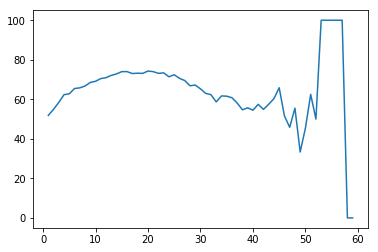

In [102]:
plt.plot(valid_frames, acc_test_list)

In [109]:
# combining variables

acc_train_list = []
acc_test_list = []
valid_frames = []

lead = 1*(npzfile['total_gold'][:,:,2] > 0)

for frame in range(1,max_frames-1):
    X = npzfile['xp'][:,frame+1,2]
    indices = np.where(X != 0)[0]
    X1 = (np.sum(lead[:,1:frame+1],axis=1) / frame).reshape(-1,1)
    
    X2 = npzfile['total_gold'][:,frame,2].reshape(-1,1)
    
    X3 = npzfile['current_gold'][:,frame,2].reshape(-1,1)
    
    X4 = npzfile['max_total_gold'][:,frame,2].reshape(-1,1)
    
    X5 = npzfile['xp'][:,frame,2].reshape(-1,1)
    
    X = np.concatenate((X1,X2,X3,X4,X5),axis=1)
    
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

(26683, 5)
frame:  1 , train: 53.3 , test:  52.04313280363224 N:  26428
(26683, 5)
frame:  2 , train: 55.48 , test:  55.49306336707911 N:  26667
(26683, 5)
frame:  3 , train: 60.62 , test:  60.49266641594584 N:  26587
(26683, 5)
frame:  4 , train: 63.56 , test:  64.21652421652422 N:  26321
(26683, 5)
frame:  5 , train: 65.5 , test:  65.07122507122507 N:  26324
(26683, 5)
frame:  6 , train: 67.34 , test:  67.63532763532764 N:  26321
(26683, 5)
frame:  7 , train: 68.82 , test:  68.98385565052232 N:  26321
(26683, 5)
frame:  8 , train: 70.39 , test:  70.04941087039148 N:  26309
(26683, 5)
frame:  9 , train: 72.12 , test:  72.5527466261167 N:  26305
(26683, 5)
frame:  10 , train: 73.36 , test:  72.18946167015407 N:  26281
(26683, 5)
frame:  11 , train: 74.75 , test:  74.06136840099104 N:  26232
(26683, 5)
frame:  12 , train: 75.66 , test:  74.67023513668515 N:  26154
(26683, 5)
frame:  13 , train: 76.64 , test:  76.30668716372021 N:  26017
(26683, 5)
frame:  14 , train: 77.55 , test:  77.7

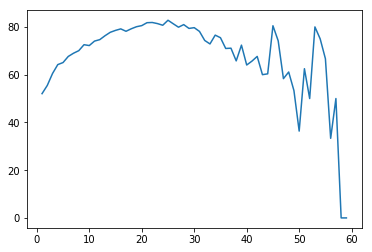

In [110]:
plt.plot(valid_frames, acc_test_list)

In [111]:
# combining variables

acc_train_list = []
acc_test_list = []
valid_frames = []

lead = 1*(npzfile['total_gold'][:,:,2] > 0)

for frame in range(1,max_frames-1):
    X = npzfile['xp'][:,frame+1,2]
    indices = np.where(X != 0)[0]
    X1 = (np.sum(lead[:,1:frame+1],axis=1) / frame).reshape(-1,1)
    
    X2 = npzfile['total_gold'][:,frame,2].reshape(-1,1)
    
    X = np.concatenate((X1,X2),axis=1)
    
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  1 , train: 52.65 , test:  51.38100643208475 N:  26428
frame:  2 , train: 55.49 , test:  54.761904761904766 N:  26667
frame:  3 , train: 60.4 , test:  60.81233546446032 N:  26587
frame:  4 , train: 63.21 , test:  64.42545109211775 N:  26321
frame:  5 , train: 65.43 , test:  64.86229819563152 N:  26324
frame:  6 , train: 66.94 , test:  67.63532763532764 N:  26321
frame:  7 , train: 68.46 , test:  68.45204178537512 N:  26321
frame:  8 , train: 69.97 , test:  69.82136069935386 N:  26309
frame:  9 , train: 71.68 , test:  71.84945827789394 N:  26305
frame:  10 , train: 72.97 , test:  72.85524063153889 N:  26281
frame:  11 , train: 74.17 , test:  74.19477796836289 N:  26232
frame:  12 , train: 75.39 , test:  74.03938061556107 N:  26154
frame:  13 , train: 76.27 , test:  75.9607993850884 N:  26017
frame:  14 , train: 77.26 , test:  77.27888523321076 N:  25833
frame:  15 , train: 78.33 , test:  77.90152403282532 N:  25588
frame:  16 , train: 78.06 , test:  78.47763643824375 N:  24367
fr

In [122]:
# only over games that last 30 minutes or fewer

acc_train_list = []
acc_test_list = []
valid_frames = []

lead = 1*(npzfile['total_gold'][:,:,2] > 0)

max_time = 30
main_indices = np.where(npzfile['num_frames'] < max_time)[0]
len(main_indices)

for frame in range(1,max_frames-1):
    X1 = (np.sum(lead[:,1:frame+1],axis=1) / frame).reshape(-1,1)[main_indices]
    
    X2 = npzfile['total_gold'][:,frame,2].reshape(-1,1)[main_indices]
    
    indices = np.where(X2 != 0)[0]
    
    X = np.concatenate((X1,X2),axis=1)
    
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[main_indices][indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  1 , train: 56.96 , test:  54.957983193277315 N:  2974
frame:  2 , train: 56.75 , test:  57.59065765212047 N:  16270
frame:  3 , train: 64.2 , test:  63.92036753445636 N:  16322
frame:  4 , train: 68.9 , test:  68.50199938480468 N:  16251
frame:  5 , train: 71.24 , test:  71.58059467918622 N:  15974
frame:  6 , train: 74.22 , test:  73.38760175328741 N:  15969
frame:  7 , train: 76.11 , test:  76.11893583724569 N:  15972
frame:  8 , train: 77.93 , test:  77.96557120500782 N:  15973
frame:  9 , train: 80.02 , test:  81.02098340119011 N:  15964
frame:  10 , train: 82.1 , test:  82.01754385964912 N:  15956
frame:  11 , train: 83.74 , test:  83.71509256353939 N:  15934
frame:  12 , train: 85.14 , test:  84.38778722064842 N:  15885
frame:  13 , train: 86.62 , test:  87.28250553622271 N:  15805
frame:  14 , train: 87.9 , test:  87.61965539246968 N:  15668
frame:  15 , train: 88.71 , test:  89.05392315143688 N:  15483
frame:  16 , train: 89.97 , test:  89.66535433070865 N:  15239
frame

In [123]:
# only over games that last 30 minutes or fewer

acc_train_list = []
acc_test_list = []
valid_frames = []

lead = 1*(npzfile['total_gold'][:,:,2] > 0)

min_time = 20
max_time = 30
main_indices = np.where((npzfile['num_frames'] < max_time) & (npzfile['num_frames'] > min_time))[0]
len(main_indices)

for frame in range(1,max_frames-1):
    X1 = (np.sum(lead[:,1:frame+1],axis=1) / frame).reshape(-1,1)[main_indices]
    
    X2 = npzfile['total_gold'][:,frame,2].reshape(-1,1)[main_indices]
    
    indices = np.where(X2 != 0)[0]
    
    X = np.concatenate((X1,X2),axis=1)
    
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[main_indices][indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  1 , train: 55.13 , test:  52.459016393442624 N:  2132
frame:  2 , train: 54.86 , test:  55.743801652892564 N:  12097
frame:  3 , train: 61.0 , test:  61.22785331685208 N:  12132
frame:  4 , train: 64.81 , test:  64.82701812191104 N:  12138
frame:  5 , train: 67.35 , test:  68.69851729818781 N:  12138
frame:  6 , train: 70.16 , test:  69.01524515863206 N:  12132
frame:  7 , train: 71.71 , test:  71.81705809641534 N:  12135
frame:  8 , train: 73.55 , test:  73.06425041186162 N:  12137
frame:  9 , train: 76.22 , test:  75.164744645799 N:  12137
frame:  10 , train: 77.94 , test:  77.97447509263071 N:  12141
frame:  11 , train: 79.72 , test:  79.74475092630712 N:  12141
frame:  12 , train: 81.43 , test:  79.85996705107084 N:  12140
frame:  13 , train: 83.38 , test:  83.15485996705108 N:  12140
frame:  14 , train: 84.91 , test:  83.89621087314663 N:  12140
frame:  15 , train: 86.22 , test:  85.25535420098846 N:  12140
frame:  16 , train: 87.71 , test:  87.27347611202636 N:  12140
fra

In [134]:
fin = 'embeddings.npz'

champion_file = np.load(fin)
print(champion_file.files)

embeddings = champion_file['champion_embeddings']

num_champions = len(embeddings)
map_champions = dict(zip(champion_file['champion_ids'], range(num_champions))) # maps champion_id to 0...num_champions
re_indexed_champions = np.vectorize(map_champions.get)(npzfile['champions'])

['champion_ids', 'champion_names', 'champion_roles_array', 'champion_embeddings', 'all_roles_dict']


In [135]:
embeddings = champion_file['champion_embeddings']
embeddings[re_indexed_champions].shape

(7302, 10, 20)

In [136]:
# calculate feature as the differencein embeddings
team_1 = np.sum(embeddings[re_indexed_champions][:,:5,:],axis=1)
team_2 = np.sum(embeddings[re_indexed_champions][:,5:,:],axis=1)
team_diff = team_1 - team_2
team_diff.shape

(7302, 20)

In [145]:
# predict using lead in total gold and difference in team embeddings

acc_train_list = []
acc_test_list = []
valid_frames = []
for frame in range(max_frames):
    X = npzfile['total_gold'][:,frame,2]
    if frame != 0:
        indices = np.where(X != 0)[0]
    else:
        indices = range(n)
    X = X.reshape((n,1))
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    X = np.concatenate((X, team_diff),axis=1)
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  0 , train: 52.84 , test:  51.94184425413264 N:  25104
frame:  1 , train: 57.65 , test:  55.40386803185437 N:  4395
frame:  2 , train: 55.0 , test:  55.58 N:  24998
frame:  3 , train: 60.44 , test:  61.231811839744864 N:  25085
frame:  4 , train: 63.3 , test:  63.23676323676324 N:  25021
frame:  5 , train: 65.35 , test:  65.11205330102968 N:  24763
frame:  6 , train: 66.98 , test:  66.53877221324717 N:  24760
frame:  7 , train: 68.26 , test:  68.34241873611953 N:  24764
frame:  8 , train: 69.55 , test:  69.77589339794065 N:  24763
frame:  9 , train: 71.44 , test:  71.18336025848141 N:  24757
frame:  10 , train: 72.65 , test:  72.94022617124394 N:  24758
frame:  11 , train: 73.85 , test:  74.21180274858528 N:  24737
frame:  12 , train: 74.88 , test:  75.08601497672535 N:  24701
frame:  13 , train: 76.14 , test:  75.7206658546488 N:  24629
frame:  14 , train: 77.33 , test:  76.60615949418724 N:  24512
frame:  15 , train: 78.0 , test:  79.05211325400082 N:  24367
frame:  16 , train

In [110]:
# predict duration

acc_train_list = []
acc_test_list = []
valid_frames = []
#for frame in range(max_frames):
for frame in range(10):
    X = npzfile['total_gold'][:,frame,2]
    indices = np.where(X != 0)[0]
    X = X.reshape((n,1))
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    X = np.concatenate((X, team_diff),axis=1)
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y2[indices], test_size=0.2, random_state=42)

        y_pred_test, y_pred_train = runLinearRegression(X_train, y_train, X_test)
        
#        print(Y_pred_train.shape, y_train.shape)

        acc_train = get_R2(y_pred_train, y_train)
        acc_test = get_R2(y_pred_test, y_test)
#        print('hi')
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
#        print('hi')
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  1 , train: 0.004420377391042063 , test:  -0.00027895974404912316 N:  4406
frame:  2 , train: 0.0013626012886175376 , test:  -0.0008782458522009762 N:  25131
frame:  3 , train: 0.001543122119584961 , test:  -0.0015581552511996222 N:  25218
frame:  4 , train: 0.0016039483013728928 , test:  -0.0020201169976044042 N:  25154
frame:  5 , train: 0.0017485523693517857 , test:  -0.0018976382906388256 N:  24896
frame:  6 , train: 0.0018707702697805528 , test:  -0.0026873427734726008 N:  24893
frame:  7 , train: 0.0013577067456801428 , test:  -0.0005059699139009499 N:  24897
frame:  8 , train: 0.0017056752073433268 , test:  -0.0011548870771815878 N:  24896
frame:  9 , train: 0.0015901542129134194 , test:  -0.0020890320876869595 N:  24889


In [111]:
print(y_train.shape, y_pred_train.shape)

(19911,) (19911,)


(array([   1.,    0.,    0.,    3.,    2.,    2.,    6.,    8.,    4.,
          11.,   22.,   30.,   69.,   87.,  158.,  251.,  369.,  522.,
         769.,  909., 1226., 1475., 1664., 1777., 1768., 1667., 1606.,
        1426., 1158.,  879.,  659.,  501.,  319.,  209.,  149.,   89.,
          58.,   22.,   17.,   14.,    1.,    3.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([25.23685842, 25.29807969, 25.35930095, 25.42052222, 25.48174348,
        25.54296475, 25.60418601, 25.66540728, 25.72662854, 25.78784981,
        25.84907107, 25.91029234, 25.9715136 , 26.03273487, 26.09395613,
        26.1551774 , 26.21639866, 26.27761993, 26.33884119, 26.40006246,
        26.46128372, 26.52250499, 26.58372626, 26.64494752, 26.70616879,
        26.76739005, 26.82861132, 26.88983258, 26.95105385, 27.01227511,
        27.07349638, 27.13471764, 27.19593891, 27.25716017, 27.31838144,
        27.3796027 , 27.44082397, 27.50204523, 27.5632665 , 27.62448776,
        27.68570

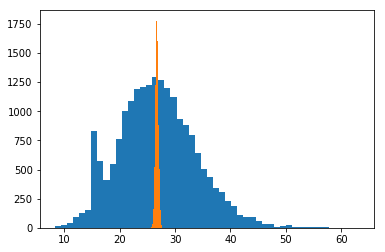

In [112]:
plt.hist(y_train,bins=50)
plt.hist(y_pred_train,bins=50)

In [98]:
get_R2(y_pred_train, y_train)

0.0016039483013728928

In [76]:
X.shape

(25237, 21)

In [129]:
# predict just using lead in total gold

acc_train_list = []
acc_test_list = []
valid_frames = []
for frame in range(max_frames):
    X = npzfile['total_gold'][:,frame,2]
    indices = np.where(X != 0)[0]
    X = X.reshape((n,1))
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  1 , train: 55.26 , test:  55.631399317406135 N:  4395
frame:  2 , train: 55.0 , test:  55.17999999999999 N:  24998
frame:  3 , train: 60.04 , test:  60.7135738489137 N:  25085
frame:  4 , train: 63.21 , test:  63.85614385614385 N:  25021
frame:  5 , train: 64.95 , test:  65.09186351706036 N:  24763
frame:  6 , train: 67.0 , test:  66.5589660743134 N:  24760
frame:  7 , train: 68.01 , test:  68.56450635978194 N:  24764
frame:  8 , train: 69.55 , test:  69.77589339794065 N:  24763
frame:  9 , train: 71.44 , test:  71.18336025848141 N:  24757
frame:  10 , train: 72.65 , test:  72.94022617124394 N:  24758
frame:  11 , train: 73.85 , test:  74.21180274858528 N:  24737
frame:  12 , train: 74.88 , test:  75.08601497672535 N:  24701
frame:  13 , train: 76.14 , test:  75.7206658546488 N:  24629
frame:  14 , train: 77.33 , test:  76.60615949418724 N:  24512
frame:  15 , train: 78.0 , test:  79.05211325400082 N:  24367
frame:  16 , train: 79.11 , test:  78.36160529582126 N:  24169
frame: 

In [30]:
# predict just using lead in total gold

acc_train_list = []
acc_test_list = []
valid_frames = []
for frame in range(max_frames):
#for frame in range(5):
    X = npzfile['total_gold'][:,:frame+1,2][valid_games]
    m = len(X)
    if frame <= 1:
        indices = range(m)
    else:
        indices = np.where(X[:,-1] != 0)[0]
    X = X.reshape((m,frame+1))
    #X = np.concatenate((X, team_1[valid_games], team_2[valid_games], team_diff[valid_games]),axis=1)
    
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[valid_games][indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  0 , train: 50.48 , test:  48.78243512974052 N:  12525
frame:  1 , train: 51.12 , test:  49.740518962075846 N:  12525
frame:  2 , train: 54.67 , test:  54.12660256410257 N:  12477
frame:  3 , train: 59.45 , test:  61.206552137435075 N:  12511
frame:  4 , train: 62.96 , test:  62.73018414731786 N:  12488
frame:  5 , train: 64.7 , test:  63.98544866612773 N:  12366
frame:  6 , train: 66.11 , test:  67.93368378487666 N:  12365
frame:  7 , train: 67.66 , test:  67.29991915925626 N:  12370
frame:  8 , train: 68.81 , test:  70.08892481810832 N:  12368
frame:  9 , train: 70.93 , test:  72.3008491710473 N:  12365
frame:  10 , train: 72.71 , test:  70.57396928051737 N:  12367
frame:  11 , train: 73.78 , test:  73.19045693489689 N:  12361
frame:  12 , train: 74.28 , test:  75.69866342648845 N:  12343
frame:  13 , train: 75.53 , test:  75.57903291344982 N:  12305
frame:  14 , train: 76.9 , test:  76.44897959183673 N:  12250
frame:  15 , train: 78.34 , test:  77.39023389413214 N:  12181
fra

In [38]:
# predict just using lead in total gold

acc_train_list = []
acc_test_list = []
valid_frames = []
for frame in range(max_frames):
#for frame in range(5):
    X = npzfile['total_gold'][:,:frame+1,2][valid_games]
    m = len(X)
    if frame <= 1:
        indices = range(m)
    else:
        indices = np.where(X[:,-1] != 0)[0]
    X = X.reshape((m,frame+1))
    X = np.concatenate((X, team_diff[valid_games]),axis=1)
    
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[valid_games][indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  0 , train: 52.52 , test:  51.64261590420632 N:  16284
frame:  1 , train: 52.98 , test:  52.34878722750997 N:  16284
frame:  2 , train: 55.31 , test:  55.610357583230574 N:  16220
frame:  3 , train: 60.28 , test:  59.77258758451137 N:  16269
frame:  4 , train: 63.58 , test:  62.57309941520468 N:  16241
frame:  5 , train: 65.09 , test:  63.59962698165993 N:  16082
frame:  6 , train: 66.46 , test:  66.63557213930348 N:  16080
frame:  7 , train: 67.63 , test:  67.21566190180236 N:  16086
frame:  8 , train: 69.43 , test:  70.68697544295928 N:  16084
frame:  9 , train: 71.33 , test:  70.08706467661692 N:  16079
frame:  10 , train: 72.05 , test:  72.79228855721394 N:  16079
frame:  11 , train: 73.24 , test:  73.98879900435594 N:  16068
frame:  12 , train: 74.4 , test:  74.797507788162 N:  16046
frame:  13 , train: 75.83 , test:  74.625 N:  15997
frame:  14 , train: 76.7 , test:  76.3653483992467 N:  15926
frame:  15 , train: 78.09 , test:  77.09056484695488 N:  15841
frame:  16 , trai

In [36]:
# predict just using lead in total gold

acc_train_list = []
acc_test_list2 = []
valid_frames = []
for frame in range(max_frames):
#for frame in range(5):
    X = npzfile['total_gold'][:,:frame+1,2][valid_games]
    m = len(X)
    if frame <= 1:
        indices = range(m)
    else:
        indices = np.where(X[:,-1] != 0)[0]
    X = X.reshape((m,frame+1))
    X = np.concatenate((X, team_diff[valid_games]),axis=1)
    
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[valid_games][indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list2.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  0 , train: 54.91 , test:  50.0 N:  7816
frame:  1 , train: 55.2 , test:  50.57544757033248 N:  7816
frame:  2 , train: 56.17 , test:  54.2068079640334 N:  7785
frame:  3 , train: 60.5 , test:  59.154929577464785 N:  7807
frame:  4 , train: 63.81 , test:  63.181526619627974 N:  7792
frame:  5 , train: 64.68 , test:  67.35885788449059 N:  7704
frame:  6 , train: 66.88 , test:  66.77482154445165 N:  7703
frame:  7 , train: 68.23 , test:  67.63942931258107 N:  7709
frame:  8 , train: 69.58 , test:  68.28793774319067 N:  7709
frame:  9 , train: 71.13 , test:  72.30869001297016 N:  7707
frame:  10 , train: 71.82 , test:  73.28145265888456 N:  7706
frame:  11 , train: 73.39 , test:  74.56197274497079 N:  7704
frame:  12 , train: 73.76 , test:  76.47823261858349 N:  7693
frame:  13 , train: 75.62 , test:  75.60339204174821 N:  7665
frame:  14 , train: 76.68 , test:  77.78505897771953 N:  7628
frame:  15 , train: 77.94 , test:  78.57613711272248 N:  7583
frame:  16 , train: 79.44 , test

In [50]:
# predict just using lead in total gold

acc_train_list = []
acc_test_list8 = []
valid_frames = []
for frame in range(max_frames):
#for frame in range(5):
    X = npzfile['total_gold'][:,:frame+1,2][valid_games]
    m = len(X)
    if frame <= 1:
        indices = range(m)
    else:
        indices = np.where(X[:,-1] != 0)[0]
    X = X.reshape((m,frame+1))
#    X = np.concatenate((X, team_diff[valid_games]),axis=1)
    
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[valid_games][indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list8.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices))
    except:
        print('frame: ', frame, '...issue')

frame:  0 , train: 50.58 , test:  48.59335038363171 N:  7816
frame:  1 , train: 51.23 , test:  49.552429667519185 N:  7816
frame:  2 , train: 54.0 , test:  51.8946692357097 N:  7785
frame:  3 , train: 59.9 , test:  58.57874519846351 N:  7807
frame:  4 , train: 62.55 , test:  63.181526619627974 N:  7792
frame:  5 , train: 63.2 , test:  66.96950032446463 N:  7704
frame:  6 , train: 66.16 , test:  66.58014276443868 N:  7703
frame:  7 , train: 67.65 , test:  67.63942931258107 N:  7709
frame:  8 , train: 69.11 , test:  68.5473411154345 N:  7709
frame:  9 , train: 70.82 , test:  71.33592736705577 N:  7707
frame:  10 , train: 71.84 , test:  73.28145265888456 N:  7706
frame:  11 , train: 73.37 , test:  74.6268656716418 N:  7704
frame:  12 , train: 73.76 , test:  76.47823261858349 N:  7693
frame:  13 , train: 75.6 , test:  75.66862361382908 N:  7665
frame:  14 , train: 76.68 , test:  77.78505897771953 N:  7628
frame:  15 , train: 77.98 , test:  78.57613711272248 N:  7583
frame:  16 , train: 79.

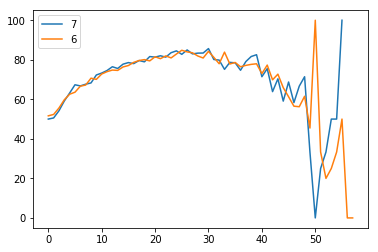

In [41]:
plt.plot(acc_test_list2,label='7')
plt.plot(acc_test_list,label='6')
plt.legend()

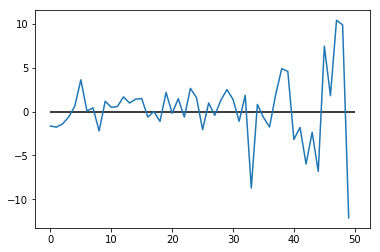

In [49]:
#diff = np.array(acc_test_list2[:50]) - np.array(acc_test_list[:50])
#diff = np.array(acc_test_list8[:50]) - np.array(acc_test_list[:50])
diff2 = np.array(acc_test_list8[:50]) - np.array(acc_test_list[:50])

plt.plot(diff)
plt.hlines(0,0,50)

In [32]:
# predict just using lead in total gold

acc_train_list = []
acc_test_list7 = []
valid_frames = []
for frame in range(max_frames):
#for frame in range(5):
    X = npzfile['total_gold'][:,:frame+1,2][valid_games]
    m = len(X)
    if frame <= min_duration:
        indices = range(m)
    else:
        indices = np.where(X[:,-1] != 0)[0]
    X = X.reshape((m,frame+1))
    #X = np.concatenate((X, team_diff[valid_games]),axis=1)
    
    if len(indices) == 0:
        continue
    # print('frame: ', frame,', number of matches: ',len(indices[0]))
    try:
        X_train, X_test, y_train, y_test = train_test_split(X[indices], Y[valid_games][indices], test_size=0.2, random_state=frame)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        acc_train_list.append(acc_train)
        acc_test_list7.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test: ' , acc_test, 'N: ', len(indices), X[indices].shape)
    except:
        print('frame: ', frame, '...issue')

frame:  0 , train: 52.68 , test:  51.4670896114195 N:  6301 (6301, 1)
frame:  1 , train: 53.13 , test:  50.27755749405234 N:  6301 (6301, 2)
frame:  2 , train: 53.49 , test:  52.101506740682005 N:  6301 (6301, 3)
frame:  3 , train: 57.86 , test:  57.33544805709754 N:  6301 (6301, 4)
frame:  4 , train: 60.79 , test:  59.63521015067407 N:  6301 (6301, 5)
frame:  5 , train: 63.02 , test:  61.934972244250595 N:  6301 (6301, 6)
frame:  6 , train: 63.91 , test:  64.63124504361618 N:  6301 (6301, 7)
frame:  7 , train: 65.32 , test:  67.0103092783505 N:  6301 (6301, 8)
frame:  8 , train: 66.88 , test:  67.32751784298176 N:  6301 (6301, 9)
frame:  9 , train: 68.02 , test:  67.24821570182395 N:  6301 (6301, 10)
frame:  10 , train: 69.13 , test:  68.67565424266455 N:  6301 (6301, 11)
frame:  11 , train: 70.26 , test:  72.32355273592387 N:  6301 (6301, 12)
frame:  12 , train: 72.86 , test:  71.37192704203014 N:  6301 (6301, 13)
frame:  13 , train: 73.06 , test:  73.83029341792229 N:  6301 (6301, 1

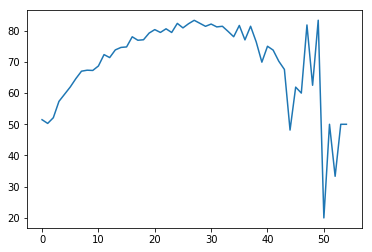

In [33]:
plt.plot(acc_test_list7)

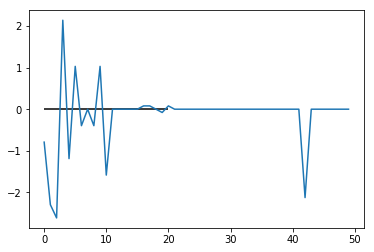

In [151]:
#diff = np.array(acc_test_list2[:50]) - np.array(acc_test_list[:50])
#diff = np.array(acc_test_list8[:50]) - np.array(acc_test_list[:50])
diff2 = np.array(acc_test_list7[:50]) - np.array(acc_test_list8[:50])

plt.plot(diff2)
plt.hlines(0,0,20)
#plt.xlim([0,20])

In [92]:
team_diff

array([[ 0.11576041, -0.33541065,  0.29905552, ...,  0.05572695,
         0.08907028, -0.03298457],
       [-0.4907985 , -0.06095341,  0.12450665, ..., -0.13059838,
        -0.05667697, -0.41038036],
       [ 0.33221704,  0.07162333,  0.00613123, ...,  0.21948028,
         0.5391406 , -0.7917012 ],
       ...,
       [ 0.30620772, -0.34311545, -0.28058288, ...,  0.78229773,
        -0.01001409,  0.40734887],
       [ 0.06581232,  0.19016945, -0.2458608 , ..., -0.647972  ,
        -0.4062418 , -0.24183774],
       [ 1.205298  ,  0.15735024,  0.8116971 , ..., -0.08414393,
        -0.19817062,  0.16945323]], dtype=float32)

In [27]:
# predict just using fractional lead in total gold

acc_train_list = []
acc_test_list = []
valid_frames = []
#for frame in range(max_frames):
for frame in range(15,40):
    X1 = npzfile['total_gold'][:,:frame+1,2][valid_games]
    X2 = npzfile['total_gold'][:,:frame+1,0][valid_games]

    m = len(X1)
    if frame <= min_duration:
        indices = range(m)
    else:
        indices = np.where(X2[:,-1] != 0)[0]
    X = X1[indices] / X2[indices]
    X = X.reshape((len(X),frame+1))
    
    if len(indices) == 0:
        continue
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, Y[valid_games][indices], test_size=0.2, random_state=42)
        acc_train, y_pred = runLogisticRegression(X_train, y_train, X_test)
        acc_test = accuracy_score(y_test, y_pred)*100
        loss_test = log_loss(y_test, y_pred)
        acc_train_list.append(acc_train)
        acc_test_list7.append(acc_test)
        valid_frames.append(frame)
        print('frame: ', frame, ', train:' ,acc_train, ', test:', acc_test, ', loss:',loss_test,'N: ', len(indices), X.shape)
    except:
        print('frame: ', frame, '...issue')

frame:  15 ...issue
frame:  16 ...issue
frame:  17 ...issue
frame:  18 ...issue
frame:  19 ...issue
frame:  20 ...issue
frame:  21 ...issue
frame:  22 ...issue
frame:  23 ...issue
frame:  24 ...issue
frame:  25 ...issue
frame:  26 ...issue
frame:  27 ...issue
frame:  28 ...issue
frame:  29 ...issue
frame:  30 ...issue
frame:  31 ...issue
frame:  32 ...issue
frame:  33 ...issue
frame:  34 ...issue
frame:  35 ...issue
frame:  36 ...issue
frame:  37 ...issue
frame:  38 ...issue
frame:  39 ...issue
